In [53]:
!pip install -q keras_cv
!pip install -q pycocotools

import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


In [54]:
VER = 6
MODEL = "xs" # yolo_v8_{MODEL}_backbone_coco
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 200
GLOBAL_CLIPNORM = 10.0
SUB_V = 1


class_ids = [
    "symbol",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "raw_datasets/ua_plates_dataset/images"
path_annot = "raw_datasets/ua_plates_dataset/annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
# jpg_files = sorted(
#     [
#         os.path.join(path_images, file_name)
#         for file_name in os.listdir(path_images)
#         if file_name.endswith(".png")
#     ]
# )

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)


bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation samples
num_val = int(len(data) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


augmenter = keras.Sequential(
    layers=[
        # keras_cv.layers.RandomShear(
        #     x_factor=0.1, y_factor=0.1, bounding_box_format="xyxy"
        # ),
        # keras_cv.layers.JitteredResize(
        #     target_size=(256, 256), scale_factor=(0.75, 1), bounding_box_format="xyxy"
        # ),
        keras_cv.layers.Resizing(
            256,
            256,
            pad_to_aspect_ratio=True,
            bounding_box_format="xyxy",
        )
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

resizing = keras.Sequential(
    layers=[
        # keras_cv.layers.Grayscale(output_channels=3),
        keras_cv.layers.Resizing(
            256,
            256,
            pad_to_aspect_ratio=True,
            bounding_box_format="xyxy",
        )
    ]
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    # return inputs["images"], inputs["bounding_boxes"]
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=8
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


100%|██████████| 3551/3551 [00:00<00:00, 5267.32it/s]


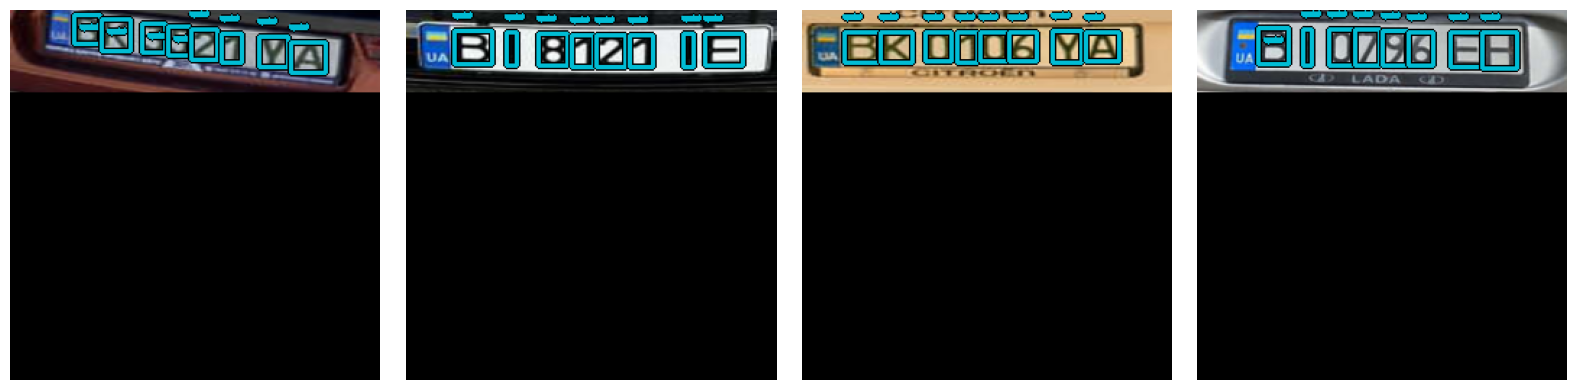

In [55]:
for images, y_true in train_ds.take(1):
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format="xyxy",
        y_true=y_true,
        # y_pred=y_pred,
        scale=4,
        rows=1,
        cols=4,
        show=True,
        font_scale=0.1,
        class_mapping=class_mapping,
    )


In [56]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    f"yolo_v8_{MODEL}_backbone_coco"
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
# yolo.summary()


In [57]:
# yolo = keras.models.load_model('yolo_m_v2.1_e0.keras', compile=False)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=LEARNING_RATE,
#     global_clipnorm=GLOBAL_CLIPNORM,
# )

# yolo.compile(
#     optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
# )

In [58]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves
        
        # self.model.save(f"yolo_{MODEL}_v{VER}.{SUB_V}_e{epoch}.keras")

        return logs


In [59]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, f"smbls_{MODEL}_v{VER}_best.keras")],
)


Epoch 1/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 228s 287ms/step - box_loss: 1.8757 - class_loss: 34.7108 - loss: 36.5865 - val_box_loss: 0.8201 - val_class_loss: 0.4371 - val_loss: 1.2572 - MaP: 0.7685 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9688 - MaP@[area=small]: 0.7685 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1034 - Recall@[max_detections=10]: 0.8132 - Recall@[max_detections=100]: 0.8132 - Recall@[area=small]: 0.8132 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - box_loss: 0.6044 - class_loss: 0.3610 - loss: 0.9654

2024-09-15 14:06:00.299805: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


710/710 ━━━━━━━━━━━━━━━━━━━━ 237s 334ms/step - box_loss: 0.6044 - class_loss: 0.3610 - loss: 0.9654 - val_box_loss: 0.6158 - val_class_loss: 0.3255 - val_loss: 0.9413 - MaP: 0.8447 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9800 - MaP@[area=small]: 0.8447 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1126 - Recall@[max_detections=10]: 0.8731 - Recall@[max_detections=100]: 0.8731 - Recall@[area=small]: 0.8731 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 3/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 227s 320ms/step - box_loss: 0.5392 - class_loss: 0.3022 - loss: 0.8414 - val_box_loss: 0.5672 - val_class_loss: 0.3089 - val_loss: 0.8761 - MaP: 0.8673 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9801 - MaP@[area=small]: 0.8673 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1146 - Recall@[max_detections=10]: 0.8970 - Recall@[max_detections=100]: 0.8970 - Recall@[area=small]: 0.8970 - R

2024-09-15 15:09:35.763191: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


710/710 ━━━━━━━━━━━━━━━━━━━━ 216s 302ms/step - box_loss: 0.3516 - class_loss: 0.1889 - loss: 0.5405 - val_box_loss: 0.4811 - val_class_loss: 0.2216 - val_loss: 0.7027 - MaP: 0.8792 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9901 - MaP@[area=small]: 0.8792 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1163 - Recall@[max_detections=10]: 0.9109 - Recall@[max_detections=100]: 0.9109 - Recall@[area=small]: 0.9109 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 19/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 222s 312ms/step - box_loss: 0.3406 - class_loss: 0.1832 - loss: 0.5238 - val_box_loss: 0.4299 - val_class_loss: 0.2142 - val_loss: 0.6441 - MaP: 0.9001 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9901 - MaP@[area=small]: 0.9001 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1185 - Recall@[max_detections=10]: 0.9264 - Recall@[max_detections=100]: 0.9264 - Recall@[area=small]: 0.9264 - 

2024-09-15 16:54:14.611549: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


710/710 ━━━━━━━━━━━━━━━━━━━━ 168s 237ms/step - box_loss: 0.2130 - class_loss: 0.1246 - loss: 0.3376 - val_box_loss: 0.4325 - val_class_loss: 0.2108 - val_loss: 0.6432 - MaP: 0.8973 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9901 - MaP@[area=small]: 0.8973 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1171 - Recall@[max_detections=10]: 0.9281 - Recall@[max_detections=100]: 0.9281 - Recall@[area=small]: 0.9281 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 51/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 168s 236ms/step - box_loss: 0.2084 - class_loss: 0.1223 - loss: 0.3307 - val_box_loss: 0.4386 - val_class_loss: 0.2150 - val_loss: 0.6536 - MaP: 0.8963 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9900 - MaP@[area=small]: 0.8963 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1173 - Recall@[max_detections=10]: 0.9251 - Recall@[max_detections=100]: 0.9251 - Recall@[area=small]: 0.9251 - 

2024-09-15 20:22:43.083494: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


710/710 ━━━━━━━━━━━━━━━━━━━━ 246s 346ms/step - box_loss: 0.1259 - class_loss: 0.0841 - loss: 0.2100 - val_box_loss: 0.4056 - val_class_loss: 0.1870 - val_loss: 0.5926 - MaP: 0.9074 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9901 - MaP@[area=small]: 0.9074 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1192 - Recall@[max_detections=10]: 0.9351 - Recall@[max_detections=100]: 0.9351 - Recall@[area=small]: 0.9351 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 115/200
710/710 ━━━━━━━━━━━━━━━━━━━━ 244s 343ms/step - box_loss: 0.1267 - class_loss: 0.0853 - loss: 0.2119 - val_box_loss: 0.4051 - val_class_loss: 0.1918 - val_loss: 0.5970 - MaP: 0.9074 - MaP@[IoU=50]: 0.9901 - MaP@[IoU=75]: 0.9901 - MaP@[area=small]: 0.9074 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.1187 - Recall@[max_detections=10]: 0.9350 - Recall@[max_detections=100]: 0.9350 - Recall@[area=small]: 0.9350 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


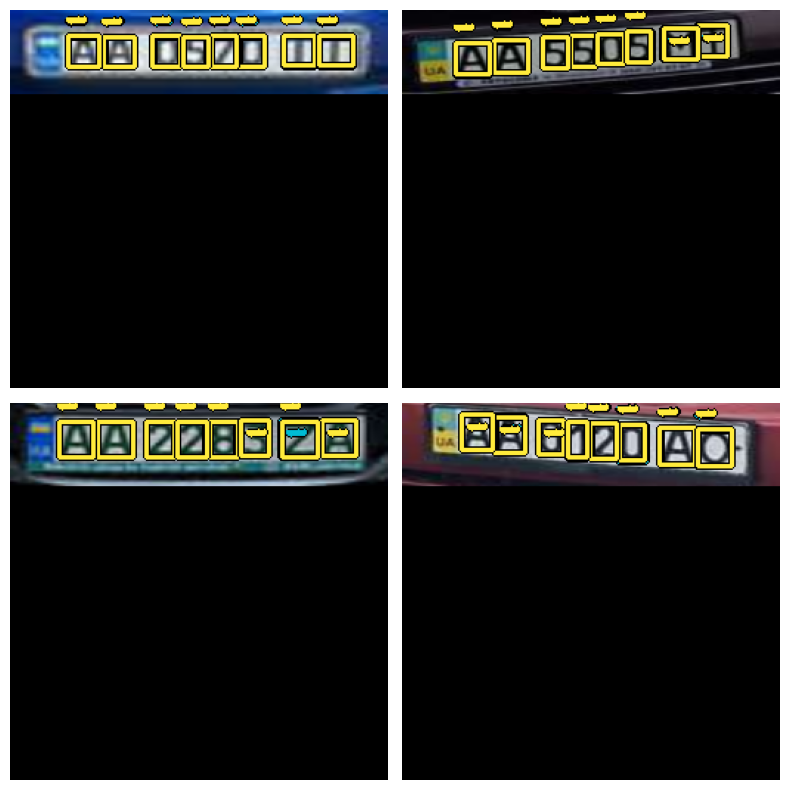

In [61]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred.pop("confidence")
    # y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.1,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")
